<a href="https://colab.research.google.com/github/Originalfemo/NYC-Taxi-Trip/blob/main/NYC_taxi_trip.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install geopandas

# Installing the modules needed for this analysis

In [ ]:
pip install descartes

In [ ]:
pip install shapely

### Importing the libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns     
sns.set()
%matplotlib inline
import datetime as dt
import warnings; warnings.simplefilter('ignore')
import descartes
import geopandas as gpd
from shapely.geometry import Point, Polygon
from IPython.core.display import HTML
from plotly.offline import iplot, init_notebook_mode
import plotly.express as px
import plotly.graph_objs as go

### Mount the google drive so we can read the dataset directly from google drive

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
df = pd.read_csv('/content/gdrive/MyDrive/nyc_taxi_trip_duration.csv')

In [ ]:
df.head(5)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id1080784,2,2016-02-29 16:40:21,2016-02-29 16:47:01,1,-73.953918,40.778873,-73.963875,40.771164,N,400
1,id0889885,1,2016-03-11 23:35:37,2016-03-11 23:53:57,2,-73.988312,40.731743,-73.994751,40.694931,N,1100
2,id0857912,2,2016-02-21 17:59:33,2016-02-21 18:26:48,2,-73.997314,40.721458,-73.948029,40.774918,N,1635
3,id3744273,2,2016-01-05 09:44:31,2016-01-05 10:03:32,6,-73.961670,40.759720,-73.956779,40.780628,N,1141
4,id0232939,1,2016-02-17 06:42:23,2016-02-17 06:56:31,1,-74.017120,40.708469,-73.988182,40.740631,N,848


### Exploring the dataset

In [ ]:
rows = df.shape[0]
cols = df.shape[1]
print("The number of rows within the dataset are {} and the number of columns are {}".format(rows,cols))


The number of rows within the dataset are 729322 and the number of columns are 11


In [ ]:
df.columns

Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration'],
      dtype='object')

Trip duration is recorded in seconds

In [ ]:
df.nunique()

id                    729322
vendor_id                  2
pickup_datetime       709359
dropoff_datetime      709308
passenger_count            9
pickup_longitude       19729
pickup_latitude        39776
dropoff_longitude      27892
dropoff_latitude       53579
store_and_fwd_flag         2
trip_duration           6296
dtype: int64

The vendor_id has two unique values (vendor_id 1 and vendor_id 2) while store_and_fwd_flag has two unique values (Y and N)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 729322 entries, 0 to 729321
Data columns (total 11 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   id                  729322 non-null  object 
 1   vendor_id           729322 non-null  int64  
 2   pickup_datetime     729322 non-null  object 
 3   dropoff_datetime    729322 non-null  object 
 4   passenger_count     729322 non-null  int64  
 5   pickup_longitude    729322 non-null  float64
 6   pickup_latitude     729322 non-null  float64
 7   dropoff_longitude   729322 non-null  float64
 8   dropoff_latitude    729322 non-null  float64
 9   store_and_fwd_flag  729322 non-null  object 
 10  trip_duration       729322 non-null  int64  
dtypes: float64(4), int64(3), object(4)
memory usage: 61.2+ MB


From the above, pickup and dropoff time is an object datatype. This will later be converted to datetime datatype for futher analysis

In [ ]:
df.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,729322.000000,729322.000000,729322.000000,729322.000000,729322.000000,729322.000000,7.293220e+05
mean,1.535403,1.662055,-73.973513,40.750919,-73.973422,40.751775,9.522291e+02
std,0.498745,1.312446,0.069754,0.033594,0.069588,0.036037,3.864626e+03
min,1.000000,0.000000,-121.933342,34.712234,-121.933304,32.181141,1.000000e+00
25%,1.000000,1.000000,-73.991859,40.737335,-73.991318,40.735931,3.970000e+02
50%,2.000000,1.000000,-73.981758,40.754070,-73.979759,40.754509,6.630000e+02
75%,2.000000,2.000000,-73.967361,40.768314,-73.963036,40.769741,1.075000e+03
max,2.000000,9.000000,-65.897385,51.881084,-65.897385,43.921028,1.939736e+06


The minimum value for passanger count shows 0 which is possibly an entry error or the driver deliberately entered 0 for some reason. We cannot be completely sure of this but an answer can be gotten by probing of the driver

Checking all passenger_count column with 0 passengers

In [ ]:
#df.loc[df['passenger_count'] == 0]

In [ ]:
df['passenger_count'].value_counts()

1    517415
2    105097
5     38926
3     29692
6     24107
4     14050
0        33
9         1
7         1
Name: passenger_count, dtype: int64

We have 33 entries with 0 number of passengers

In [ ]:
df.groupby(["passenger_count", "vendor_id"])["vendor_id"].count()

passenger_count  vendor_id
0                1                19
                 2                14
1                1            275285
                 2            242130
2                1             45996
                 2             59101
3                1             11341
                 2             18351
4                1              5955
                 2              8095
5                1               174
                 2             38752
6                1                71
                 2             24036
7                2                 1
9                2                 1
Name: vendor_id, dtype: int64

The trip duration column is one of the major variables we will work with for this dataset. Lets see a boxplot of the trip_duration column

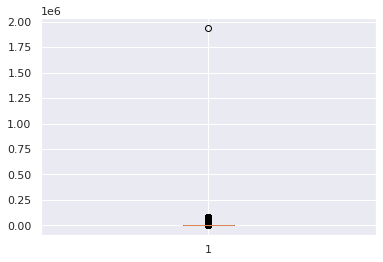

In [ ]:
plt.boxplot(df['trip_duration'])
plt.show()

From the above boxplot, we notice there is a major outlier. 

In [ ]:
#sns.boxplot(df['trip_duration'])

In [ ]:
df['trip_duration'].sort_values(ascending = False)#this reflects the id and the trip duration in seconds

21813     1939736
259437      86391
119185      86387
177225      86378
496391      86377
           ...   
312992          1
398887          1
622664          1
323299          1
296874          1
Name: trip_duration, Length: 729322, dtype: int64

We notice a 1,939,736 seconds trip in the above. This number is the outlier in our boxplot

In [ ]:
#convert the outlier to hours
1939736/3600

538.8155555555555

The trip when converted to hours amounts to 538 hours. This is impossible, so we have to drop that row

In [ ]:
df.loc[df['trip_duration'] == 1939736]

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
21813,id1864733,1,2016-01-05 00:19:42,2016-01-27 11:08:38,1,-73.78965,40.643559,-73.95681,40.773087,N,1939736


In [ ]:
df.drop(df[df['trip_duration'] == 1939736].index, inplace = True)

Now that the row has been dropped, we can plot the boxplot again and look at the distribution

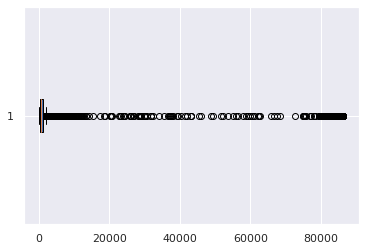

In [ ]:
plt.boxplot(df['trip_duration'], patch_artist=True, meanline=True, vert=False)
plt.show()

From the above boxplot, we can still see so many outliers

In [ ]:
df['trip_duration'].sort_values(ascending = False)

259437    86391
119185    86387
177225    86378
496391    86377
90557     86369
          ...  
398887        1
95823         1
323299        1
533760        1
102646        1
Name: trip_duration, Length: 729321, dtype: int64

We have trips running to over 86000 seconds

In [ ]:
86391/3600

23.9975

These trips run up to 23 hours. This seems to also be impossible, but first, let us check the distance between the pickup and dropoff points

In [ ]:
from geopy.distance import great_circle

In [ ]:
def cal_distance(pickup_latitude, pickup_longitude, dropoff_latitude, dropoff_longitude):
  start_coordinates = (pickup_latitude, pickup_longitude)
  stop_coordinates = (dropoff_latitude, dropoff_longitude)

  return great_circle(start_coordinates, stop_coordinates).km

In [ ]:
df['dist_in_km'] = df.apply(lambda x: cal_distance(x['pickup_latitude'], x['pickup_longitude'],
                                                     x['dropoff_latitude'], x['dropoff_longitude']),
                              axis = 1)

In [ ]:
df.head(5)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,dist_in_km
0,id1080784,2,2016-02-29 16:40:21,2016-02-29 16:47:01,1,-73.953918,40.778873,-73.963875,40.771164,N,400,1.199074
1,id0889885,1,2016-03-11 23:35:37,2016-03-11 23:53:57,2,-73.988312,40.731743,-73.994751,40.694931,N,1100,4.129117
2,id0857912,2,2016-02-21 17:59:33,2016-02-21 18:26:48,2,-73.997314,40.721458,-73.948029,40.774918,N,1635,7.250763
3,id3744273,2,2016-01-05 09:44:31,2016-01-05 10:03:32,6,-73.961670,40.759720,-73.956779,40.780628,N,1141,2.361101
4,id0232939,1,2016-02-17 06:42:23,2016-02-17 06:56:31,1,-74.017120,40.708469,-73.988182,40.740631,N,848,4.328540


Now that we have our distance in km, we can check the distance of some of the rows with over 3hours i.e 10800 seconds in trip duration

In [ ]:
df2 = df.loc[df['trip_duration'] >= 10800]#10800 seconds converted to hours is 3 hours
df2.head(5)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,dist_in_km
15,id2930166,2,2016-02-21 01:56:14,2016-02-22 01:52:18,1,-74.002876,40.734131,-73.955399,40.767502,N,86164,5.455644
610,id2903714,2,2016-01-13 07:29:02,2016-01-14 00:00:00,6,-73.990753,40.730415,-73.968506,40.750965,N,59458,2.955411
1372,id2724397,2,2016-01-24 12:46:41,2016-01-25 00:00:00,1,-73.972191,40.754681,-73.776360,40.645866,N,40399,20.467934
3018,id1734527,2,2016-06-17 12:29:41,2016-06-18 12:28:43,1,-73.981789,40.746292,-73.984619,40.763962,N,86342,1.979194
3543,id1460495,2,2016-04-13 22:06:43,2016-04-14 22:02:28,1,-73.974472,40.753895,-73.971481,40.795464,N,86145,4.629097


In [ ]:
df2['dist_in_km'].sort_values(ascending = False)

490372    173.029602
310115    135.275778
415974     60.598271
526827     42.353731
155011     24.166604
             ...    
661542      0.018732
536498      0.001273
481737      0.001065
453300      0.000643
149736      0.000000
Name: dist_in_km, Length: 1030, dtype: float64

After getting the total distance travelled in km and setting the trip duration to anything equal to or more than 3hours(10800 seconds), we have pulled out the table and checked the highest km travelled within 3 hours and it was returned as approx. 173 km. 

From further calculation according to https://www.omnicalculator.com/everyday-life/drive-time a 173km trip with an average speed of 45 mph and a 30 minute break in between trip, it takes 2 hours and 53 minutes to complete such a trip.

Based on this calculation, it might be safe to drop all rows whose trip_duration spans 3hours or more. Besides, the total number of rows which have a trip duration of 3 hours or more is a little over 1000 rows which is less than 1% of the dataset

In [ ]:
df.drop(df[df['trip_duration'] >= 10800].index, inplace = True)

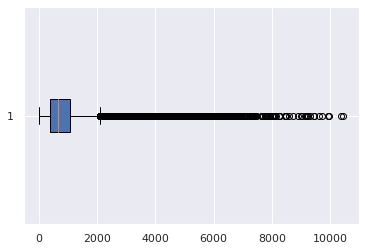

In [ ]:
plt.boxplot(df['trip_duration'], patch_artist=True, meanline=True, vert=False)
plt.show()

After dropping the rows with trip duration of 3 hours or more, we can still see some outliers in our data, nut it seems to be much better than it was

Due to the low distance covered during the trip in comparison with the time spent on the trip, it might be better to visualize our distance column and check for outliers and if these outliers dont seem to match the trip duration (rationally) they might be dropped

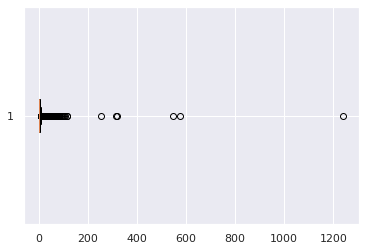

In [ ]:
plt.boxplot(df['dist_in_km'], patch_artist=True, meanline=True, vert=False)
plt.show()

From the above, we see there are a number of outliers beyond the 200 km mark, so we can filter our dataset by dist_in_km over 200km

In [ ]:
df['dist_in_km'].sort_values(ascending = False)

244913    1240.910430
621372     574.876255
441429     545.854270
654569     320.126227
697620     314.764648
             ...     
547110       0.000000
57287        0.000000
413557       0.000000
332449       0.000000
303221       0.000000
Name: dist_in_km, Length: 728291, dtype: float64

In [ ]:
df.loc[df['dist_in_km'] >= 200]

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,dist_in_km
244913,id2306955,1,2016-05-07 18:58:53,2016-05-07 19:12:05,1,-72.809669,51.881084,-73.987228,40.750599,N,792,1240.910430
441429,id0982904,1,2016-04-28 13:32:14,2016-04-28 14:14:09,2,-73.870682,40.773598,-79.817978,38.963852,N,2515,545.854270
621372,id2644780,1,2016-05-03 16:24:07,2016-05-03 17:18:34,2,-73.991325,40.750023,-79.518616,43.921028,N,3267,574.876255
654569,id0116374,1,2016-04-02 20:33:19,2016-04-02 20:38:01,1,-74.007095,40.717113,-76.963242,38.946033,N,282,320.126227
695286,id0401529,2,2016-06-02 15:19:35,2016-06-02 15:32:59,1,-73.980751,40.757111,-74.240051,38.478298,N,804,254.363882
697620,id0978162,1,2016-02-24 16:20:59,2016-02-24 16:35:34,4,-75.354332,34.712234,-73.834923,32.181141,N,875,314.764648


From the above, we have filtered our dataset by distance over 200 km and we can see that the distance covered and the duration of each trip when calculated does not really tally.

On one hand, the driver might have failed to clock in a new dropoff latitude and longitude while dropping off an old passenger, thus making the distance continue to read even when there is a new passenger in the taxi.

A good way to know if the above is true is to filter the dataset by the driver's id, but each entry for a driver's id is unique.

By choice, we can either leave or drop these rows, but I will drop them.

In [ ]:
df.drop(df[df['dist_in_km'] >= 200].index, inplace = True)

Now we can plot our boxplot again

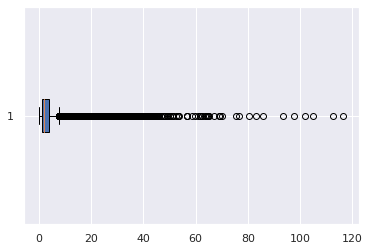

In [ ]:
plt.boxplot(df['dist_in_km'], patch_artist=True, meanline=True, vert=False)
plt.show()

We earlier noticed that the pickup and dropoff datetime have datatype object but we need to convert it into a datetime datatype and further extract data from it for before further EDA can be carried out on the dataset

In [ ]:
df['pickup_datetime']=pd.to_datetime(df['pickup_datetime'])
df['dropoff_datetime']=pd.to_datetime(df['dropoff_datetime'])

After successful conversion to datetime format, further information was extracted from the pickup_datetime and dropoff_datetime. From the datetime, the day the trip was made, hour the trip was made, and the month the trip was made was made extracted from the pickup and dropoff datetime column

In [ ]:
df['pickup_day']=df['pickup_datetime'].dt.day_name()
df['dropoff_day']=df['dropoff_datetime'].dt.day_name()
df['pickup_hour']=df['pickup_datetime'].dt.hour
df['dropoff_hour']=df['dropoff_datetime'].dt.hour
df['pickup_month']=df['pickup_datetime'].dt.month
df['dropoff_month']=df['dropoff_datetime'].dt.month

In [ ]:
pd.set_option("display.max_columns", 100)#this is used to display more columns. Python sometimes limits the no of columns dispayed and represents the missing ones with ...
df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,dist_in_km,pickup_day,dropoff_day,pickup_hour,dropoff_hour,pickup_month,dropoff_month
0,id1080784,2,2016-02-29 16:40:21,2016-02-29 16:47:01,1,-73.953918,40.778873,-73.963875,40.771164,N,400,1.199074,Monday,Monday,16,16,2,2
1,id0889885,1,2016-03-11 23:35:37,2016-03-11 23:53:57,2,-73.988312,40.731743,-73.994751,40.694931,N,1100,4.129117,Friday,Friday,23,23,3,3
2,id0857912,2,2016-02-21 17:59:33,2016-02-21 18:26:48,2,-73.997314,40.721458,-73.948029,40.774918,N,1635,7.250763,Sunday,Sunday,17,18,2,2
3,id3744273,2,2016-01-05 09:44:31,2016-01-05 10:03:32,6,-73.961670,40.759720,-73.956779,40.780628,N,1141,2.361101,Tuesday,Tuesday,9,10,1,1
4,id0232939,1,2016-02-17 06:42:23,2016-02-17 06:56:31,1,-74.017120,40.708469,-73.988182,40.740631,N,848,4.328540,Wednesday,Wednesday,6,6,2,2


From the pickup and dropoff hour, futher data can be drawn from it. We can divide it into different time frames e.g. early hours such as 6am-11am can be classified as morning etc.

In [ ]:
conditions = [
    df['pickup_hour'] == 0,
    ((df['pickup_hour'] >= 1) & (df['pickup_hour'] <= 6)),
    ((df['pickup_hour'] > 6) & (df['pickup_hour'] <= 11)),
    ((df['pickup_hour'] > 11) & (df['pickup_hour'] <= 18))
]

choices = [
    'Midnight',
    'Early Hours',
    'Morning',
    'Afternoon'
]

# create a new column or assign it to an existing
# the last param in np.select is default
df['pickup_time_bin'] = np.select(conditions, choices, 'Evening')

In [ ]:
conditions = [
    df['dropoff_hour'] == 0,
    ((df['dropoff_hour'] >= 1) & (df['dropoff_hour'] <= 6)),
    ((df['dropoff_hour'] > 6) & (df['dropoff_hour'] <= 11)),
    ((df['dropoff_hour'] > 11) & (df['dropoff_hour'] <= 18))
]

choices = [
    'Midnight',
    'Early Hours',
    'Morning',
    'Afternoon'
]

# create a new column or assign it to an existing
# the last param in np.select is default
df['dropoff_time_bin'] = np.select(conditions, choices, 'Evening')

## Mapping out the dataset based on the latitude and longitude

Importing the map

In [ ]:
street_map = gpd.read_file('/content/gdrive/MyDrive/Colab Notebooks/Borough/geo_export_2f4f4cee-2256-46fc-9c6d-bae79683f79e.shp')

In [ ]:
street_map

,boro_code,boro_name,shape_area,shape_leng,geometry
0,1.0,Manhattan,6.366038e+08,361611.823950,"MULTIPOLYGON (((-74.01093 40.68449, -74.01193 ..."
1,2.0,Bronx,1.187245e+09,464650.051822,"MULTIPOLYGON (((-73.89681 40.79581, -73.89694 ..."
2,3.0,Brooklyn,1.934091e+09,729592.941749,"MULTIPOLYGON (((-73.86706 40.58209, -73.86769 ..."
3,4.0,Queens,3.044042e+09,900087.667215,"MULTIPOLYGON (((-73.82645 40.59053, -73.82642 ..."
4,5.0,Staten Island,1.623757e+09,325956.009000,"MULTIPOLYGON (((-74.05051 40.56642, -74.05047 ..."


In [ ]:
from geopandas import GeoDataFrame

In [ ]:
# designate coordinate system
crs = {"init":"EPSG:4326"}
# zip x and y coordinates into single feature
geometry = [Point(xy) for xy in zip(df['pickup_longitude'], df['pickup_latitude'])]
# create GeoPandas dataframe
geo_df = gpd.GeoDataFrame(df, 
                          crs = crs, 
                          geometry = geometry)


In [ ]:
geo_df.head(5)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,dist_in_km,pickup_day,dropoff_day,pickup_hour,dropoff_hour,pickup_month,dropoff_month,pickup_time_bin,dropoff_time_bin,geometry
0,id1080784,2,2016-02-29 16:40:21,2016-02-29 16:47:01,1,-73.953918,40.778873,-73.963875,40.771164,N,400,1.199074,Monday,Monday,16,16,2,2,Afternoon,Afternoon,POINT (-73.95392 40.77887)
1,id0889885,1,2016-03-11 23:35:37,2016-03-11 23:53:57,2,-73.988312,40.731743,-73.994751,40.694931,N,1100,4.129117,Friday,Friday,23,23,3,3,Evening,Evening,POINT (-73.98831 40.73174)
2,id0857912,2,2016-02-21 17:59:33,2016-02-21 18:26:48,2,-73.997314,40.721458,-73.948029,40.774918,N,1635,7.250763,Sunday,Sunday,17,18,2,2,Afternoon,Afternoon,POINT (-73.99731 40.72146)
3,id3744273,2,2016-01-05 09:44:31,2016-01-05 10:03:32,6,-73.961670,40.759720,-73.956779,40.780628,N,1141,2.361101,Tuesday,Tuesday,9,10,1,1,Morning,Morning,POINT (-73.96167 40.75972)
4,id0232939,1,2016-02-17 06:42:23,2016-02-17 06:56:31,1,-74.017120,40.708469,-73.988182,40.740631,N,848,4.328540,Wednesday,Wednesday,6,6,2,2,Early Hours,Early Hours,POINT (-74.01712 40.70847)


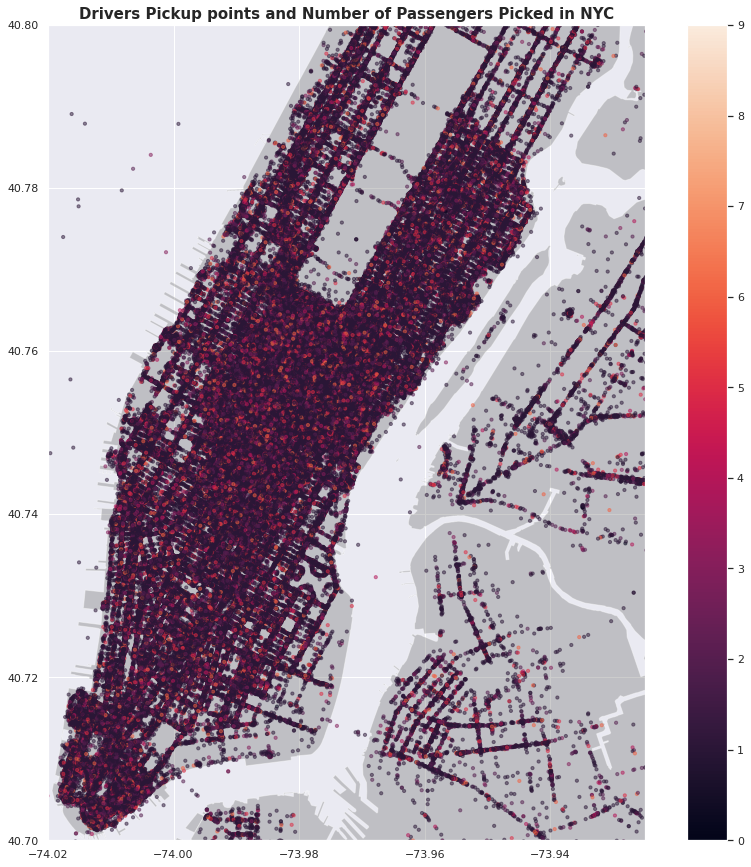

In [ ]:
# create figure and axes, assign to subplot
fig, ax = plt.subplots(figsize=(15, 15))
# add .shp mapfile to axes
street_map.plot(ax=ax, alpha=0.4,color='grey')
# add geodataframe to axes
# make datapoints transparent using alpha
# assign size of points using markersize
geo_df.plot(column='passenger_count',ax=ax,alpha=0.5, legend=True,markersize=10)
# add title to graph
plt.title('Drivers Pickup points and Number of Passengers Picked in NYC', fontsize=15,fontweight='bold')
# set latitiude and longitude boundaries for map display
plt.xlim(-74.02,-73.925)
plt.ylim( 40.7,40.8)
# show map
plt.show()

In [ ]:
crs = {"init":"EPSG:4326"}
# zip x and y coordinates into single feature
geometry = [Point(xy) for xy in zip(df['dropoff_longitude'], df['dropoff_latitude'])]
# create GeoPandas dataframe
geo_df1 = gpd.GeoDataFrame(df, 
                          crs = crs, 
                          geometry = geometry)

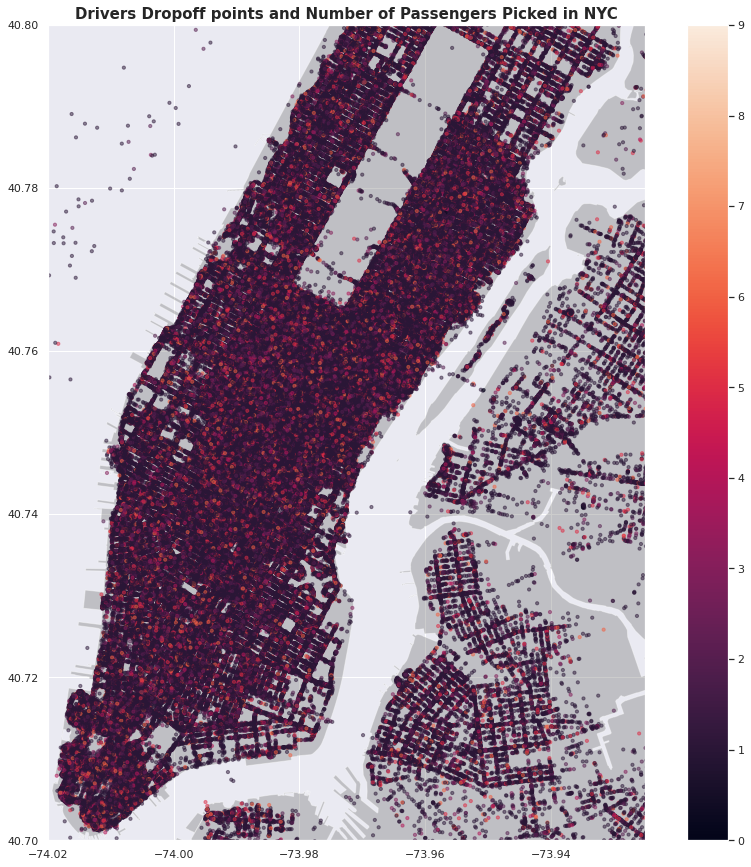

In [ ]:
# create figure and axes, assign to subplot
fig, ax = plt.subplots(figsize=(15, 15))
# add .shp mapfile to axes
street_map.plot(ax=ax, alpha=0.4,color='grey')
# add geodataframe to axes
# make datapoints transparent using alpha
# assign size of points using markersize
geo_df1.plot(column='passenger_count',ax=ax,alpha=0.5, legend=True,markersize=10)
# add title to graph
plt.title('Drivers Dropoff points and Number of Passengers Picked in NYC', fontsize=15,fontweight='bold')
# set latitiude and longitude boundaries for map display
plt.xlim(-74.02,-73.925)
plt.ylim( 40.7,40.8)
# show map
plt.show()

## UNIVARIATE ANALYSIS

In [ ]:
df.columns

Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration', 'dist_in_km', 'pickup_day', 'dropoff_day',
       'pickup_hour', 'dropoff_hour', 'pickup_month', 'dropoff_month',
       'pickup_time_bin', 'dropoff_time_bin', 'geometry'],
      dtype='object')

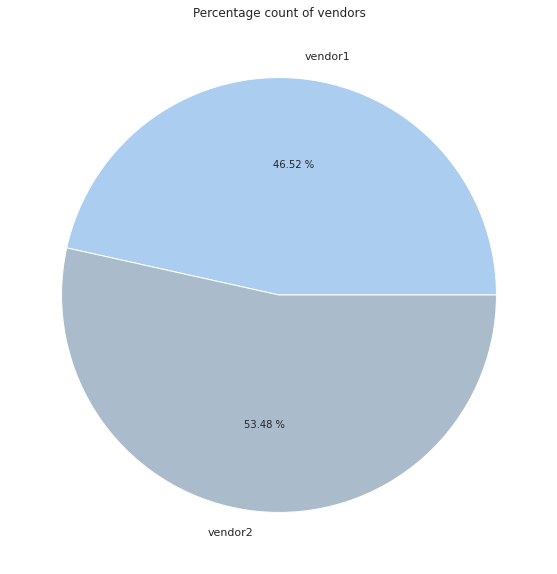

In [ ]:
vendor1 = df.loc[df['vendor_id'] == 1].count()[0]
vendor2 = df.loc[df['vendor_id'] == 2].count()[0]

plt.figure(figsize=(15,10))

labels = ['vendor1', 'vendor2']
colors = ['#abcdef', '#aabbcc']

plt.pie([vendor1, vendor2], labels = labels, colors=colors, autopct='%.2f %%')

plt.title('Percentage count of vendors')

plt.show()

There is no much difference between the number of drivers who fall under vendor 2 and vendor 1. The exact number of drivers who fall into the two categories can be viewed below

In [ ]:
df.groupby('vendor_id')['vendor_id'].count()

vendor_id
1    338824
2    389461
Name: vendor_id, dtype: int64

#### Trip Frequency Based on Number of Passenger 

In [ ]:
passenger_list=df["passenger_count"].unique()
passenger_count = df['passenger_count'].value_counts().reset_index()
pc_fig = px.bar(passenger_count, x = 'index', y = 'passenger_count', text = 'passenger_count', color = 'passenger_count',
              title = 'Frequency of Number of Passengers',
              labels = {'index': 'Number of passengers', 'passenger_count' : 'Count'})
pc_fig.update_layout(showlegend=False, width=800)
pc_fig.show()

Most cabs have 1 passenger for a higher number of its trips, but no cab had 8 passengers at the same time. 

7 passengers were in a cab at the same time only once, same with 9 passengers. This occured once

In [ ]:
df.groupby('passenger_count')['passenger_count'].count()

passenger_count
0        33
1    516808
2    104937
3     29633
4     14027
5     38810
6     24035
7         1
9         1
Name: passenger_count, dtype: int64

In [ ]:
df.groupby('store_and_fwd_flag')['store_and_fwd_flag'].count()

store_and_fwd_flag
N    724245
Y      4040
Name: store_and_fwd_flag, dtype: int64

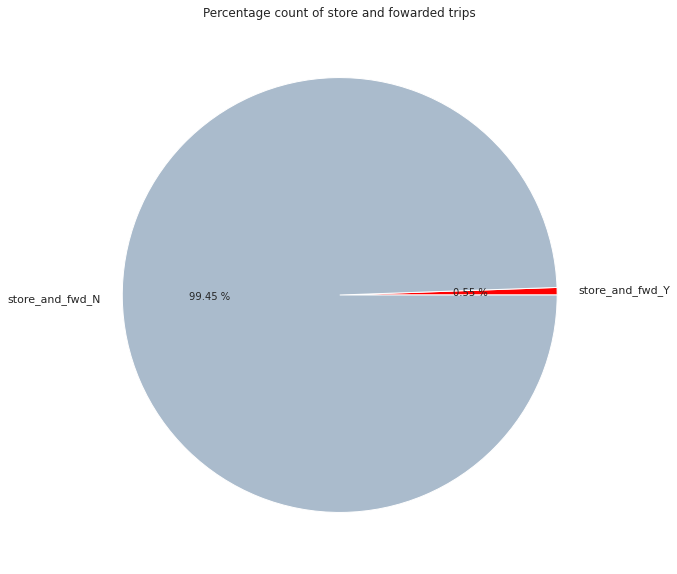

In [ ]:
store_and_fwd_Y = df.loc[df['store_and_fwd_flag'] == 'Y'].count()[0]
store_and_fwd_N = df.loc[df['store_and_fwd_flag'] == 'N'].count()[0]

plt.figure(figsize=(15,10))

labels = ['store_and_fwd_Y', 'store_and_fwd_N']
colors = ['red', '#aabbcc']


plt.pie([store_and_fwd_Y, store_and_fwd_N], labels = labels, colors=colors, autopct='%.2f %%')

plt.title('Percentage count of store and fowarded trips')

plt.show()

The above chart reflects that less than 1% of the trips were stored before fowarding

#### Trip Frequency by the Hour 

In [ ]:
pickup_count = df['pickup_hour'].value_counts().reset_index()
pickup_fig = px.bar(pickup_count, x = 'index', y = 'pickup_hour', text = 'pickup_hour', color = 'pickup_hour',
              title = 'Pickup Hour Frequency',
              labels = {'index': 'Hours', 'pickup_hour' : 'Frequency'})
pickup_fig.update_layout(showlegend=True, width=800)
pickup_fig.show()


dropoff_count = df['dropoff_hour'].value_counts().reset_index()
dropoff_fig = px.bar(dropoff_count, x = 'index', y = 'dropoff_hour', text = 'dropoff_hour', color = 'dropoff_hour',
              title = 'Dropoff Hour Frequency',
              labels = {'index': 'Hours', 'dropoff_hour' : 'Frequency'})
dropoff_fig.update_layout(showlegend=True, width=800)
dropoff_fig.show()

There are usually more trips carried out between the 18th and 19th hour of the day. This could be because people would be returning home at this time

#### Trip Frequency by Time of Day/Time Bin

In [ ]:
ptime_of_day_count = df['pickup_time_bin'].value_counts().reset_index()
ptime_of_day_fig = px.bar(ptime_of_day_count, x = 'index', y = 'pickup_time_bin', text = 'pickup_time_bin', color = 'pickup_time_bin',
              title = 'Pickup Time Bin Frequency',
              labels = {'index': 'Time of Day', 'pickup_time_bin' : 'Frequency'})
ptime_of_day_fig.update_layout(showlegend=True, width=800)
ptime_of_day_fig.show()


dtime_of_day_count = df['dropoff_time_bin'].value_counts().reset_index()
dtime_of_day_fig = px.bar(dtime_of_day_count, x = 'index', y = 'dropoff_time_bin', text = 'dropoff_time_bin', color = 'dropoff_time_bin',
              title = 'Dropoff Time Bin Frequency',
              labels = {'index': 'Time of Day', 'dropoff_time_bin' : 'Frequency'})
dtime_of_day_fig.update_layout(showlegend=True, width=800)
dtime_of_day_fig.show()

The Afternoon and Evening bins recorded the most number of trips. It is important to remember that while binning, the 18th hour of the day fell to the afternoon bin and the 19th hour to the evening bin. 

These hours mentioned above recorded the highest number of trips

#### Trips Frequency per Month

In [ ]:
pmonth_count = df['pickup_month'].value_counts().reset_index()
pmonth_fig = px.bar(pmonth_count, x = 'index', y = 'pickup_month', text = 'pickup_month', color = 'pickup_month',
              title = 'Pickup Month Frequency',
              labels = {'index': 'Month', 'pickup_month' : 'Frequency'})
pmonth_fig.update_layout(showlegend=True, width=800)
pmonth_fig.show()


dmonth_count = df['dropoff_month'].value_counts().reset_index()
dmonth_fig = px.bar(dmonth_count, x = 'index', y = 'dropoff_month', text = 'dropoff_month', color = 'dropoff_month',
              title = 'Dropoff Month Frequency',
              labels = {'index': 'Month', 'dropoff_month' : 'Frequency'})
dmonth_fig.update_layout(showlegend=True, width=800)
dmonth_fig.show()

This dataset spans over a duration of 6 months, but from the dropoff months, we notice 47 trips spanning into the 7th month. This could likely be because a trip was ordered late in the night and spanned across to the next day which could be a new month

In [ ]:
df.loc[df['dropoff_month'] == 7]

In [ ]:
df.columns

Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration', 'dist_in_km', 'pickup_day', 'dropoff_day',
       'pickup_hour', 'dropoff_hour', 'pickup_month', 'dropoff_month',
       'pickup_time_bin', 'dropoff_time_bin', 'geometry'],
      dtype='object')

#### Trip Frequency by Day of The Week

In [ ]:
pday_count = df['pickup_day'].value_counts().reset_index()
pday_fig = px.bar(pday_count, x = 'index', y = 'pickup_day', text = 'pickup_day', color = 'pickup_day',
              title = 'Pickup Days Frequency',
              labels = {'index': 'Days of The Week', 'pickup_day' : 'Frequency'})
pday_fig.update_layout(showlegend=True, width=800)
pday_fig.show()


dday_count = df['dropoff_day'].value_counts().reset_index()
dday_fig = px.bar(dday_count, x = 'index', y = 'dropoff_day', text = 'dropoff_day', color = 'dropoff_day',
              title = 'Dropoff Days Frequency',
              labels = {'index': 'Days of The Week', 'dropoff_day' : 'Frequency'})
dday_fig.update_layout(showlegend=True, width=800)
dday_fig.show()

The above shows that more trips were carried out during the weekend. This is expected as it seems people tend to move around more during the weekend

## BIVARIATE ANALYSIS

In [ ]:
from scipy import stats

#### Scatter Plot Between the Distance and Trip Duration

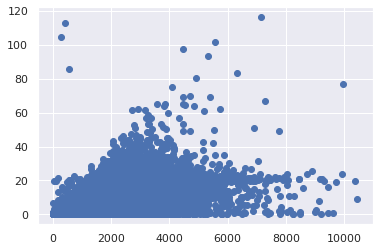

In [ ]:
x = df['trip_duration']
y = df['dist_in_km']
plt.scatter(x,y)

In [ ]:
slope, intercept, r, p, std_err = stats.linregress(x, y)
def myfunc(x):
    return slope * x + intercept
mymodel = list(map(myfunc, x))

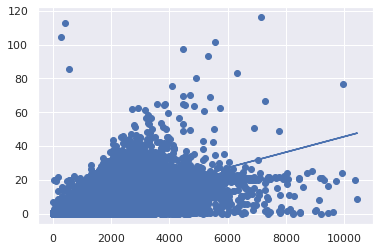

In [ ]:
plt.scatter(x,y)
plt.plot(x, mymodel)
plt.show()

There is a positive relationship between the trip duration and distance

#### Correlation Plot Between All Variables of the Dataset

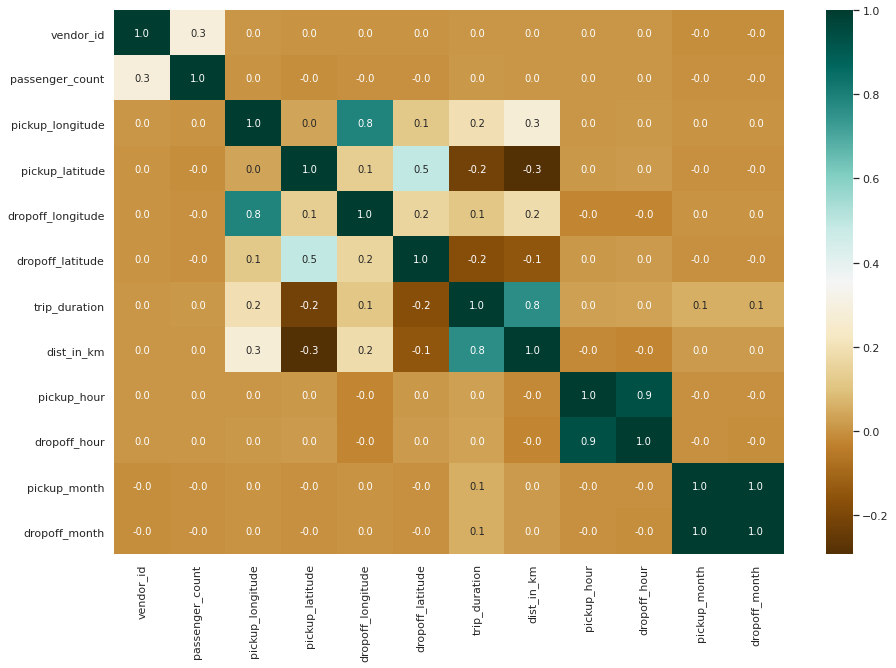

In [ ]:
corr = df.corr()
f,ax = plt.subplots(figsize=(15, 10))
sns.heatmap(df.corr(), annot=True, fmt= '.1f',ax=ax, cmap="BrBG")
sns.set(font_scale=1.25)
plt.show()

### BIVARIATE ANALYSIS BASED ON THE DISTANCE COVERED

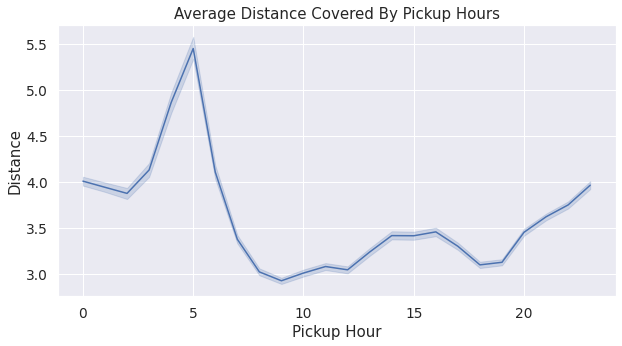

In [142]:
plt.figure(figsize = (10,5))
ax = sns.lineplot(x = 'pickup_hour', y = 'dist_in_km', data = df)
ax.set(xlabel = 'Pickup Hour', ylabel = 'Distance', title = 'Average Distance Covered By Pickup Hours')
plt.show()

5am has the highest average distance covered. Between 24th hour (0), and 5am, the distance covered continues to increase.


An answer for this rise in distance covered can be gotten if the behavioural pattern or movement pattern of individuals is looked into

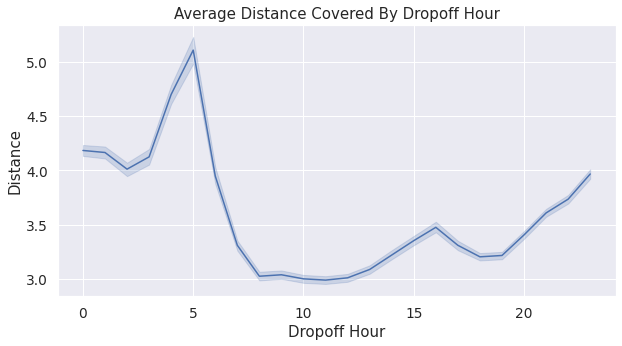

In [143]:
plt.figure(figsize = (10,5))
ax1 = sns.lineplot(x = 'dropoff_hour', y = 'dist_in_km', data = df)
ax1.set(xlabel = 'Dropoff Hour', ylabel = 'Distance', title = 'Average Distance Covered By Dropoff Hour')
plt.show()

#### Distance Covered by Day of the Week

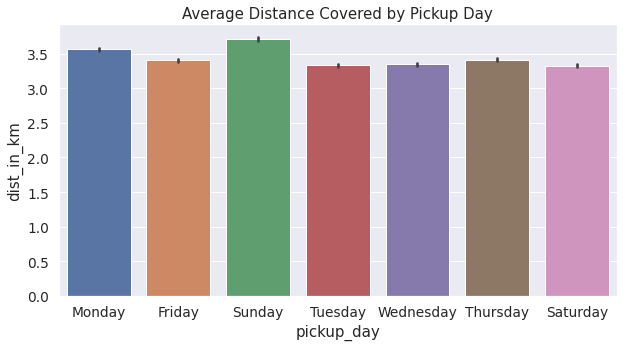

In [140]:
plt.figure(figsize=(10,5))
sns.barplot(x = 'pickup_day', y = 'dist_in_km', data = df)
plt.title('Average Distance Covered by Pickup Day')
plt.show()

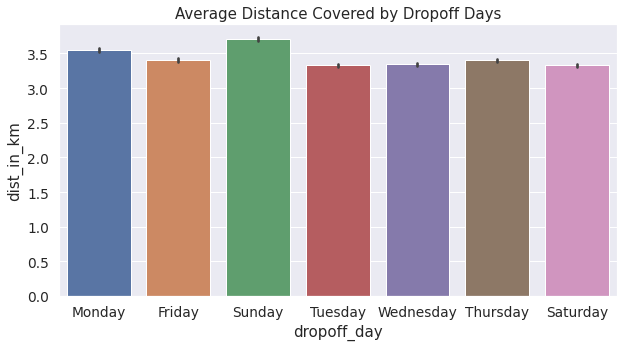

In [141]:
plt.figure(figsize = (10,5))
sns.barplot(x = 'dropoff_day', y = 'dist_in_km', data = df)
plt.title('Average Distance Covered by Dropoff Days')
plt.show()

The average distance covered during trips is more on Sundays than any other day

#### Vendor's Average Distance

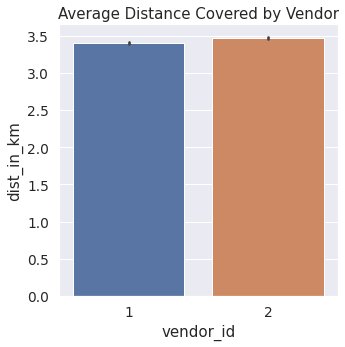

In [139]:
plt.figure(figsize=(5,5))
sns.barplot(x = 'vendor_id', y = 'dist_in_km', data = df)
plt.title('Average Distance Covered by Vendor')
plt.show()

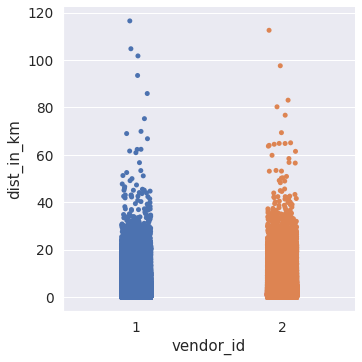

In [89]:
sns.catplot(x = 'vendor_id', y = 'dist_in_km', data = df)

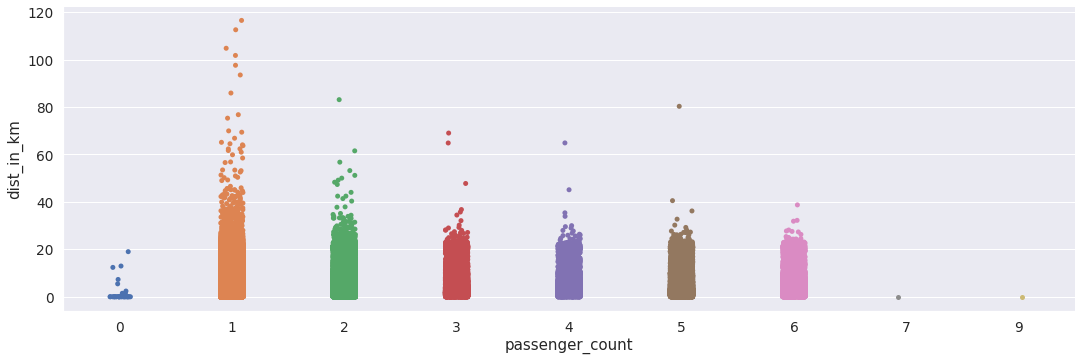

In [107]:
sns.catplot(x = 'passenger_count', y = 'dist_in_km', data = df, aspect = 3)

Cab with one passenger travelled more distance in comparison to when there are more passengers in a cab.

It seems the more passengers are in a cab, the lesser the distance they travel

## Trip Duration Analysis

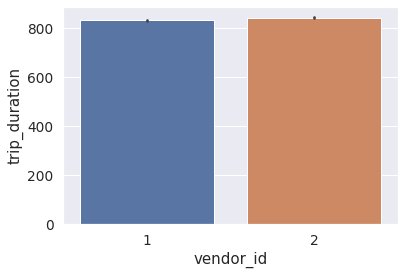

In [96]:
sns.barplot(x="vendor_id", y="trip_duration", data=df)

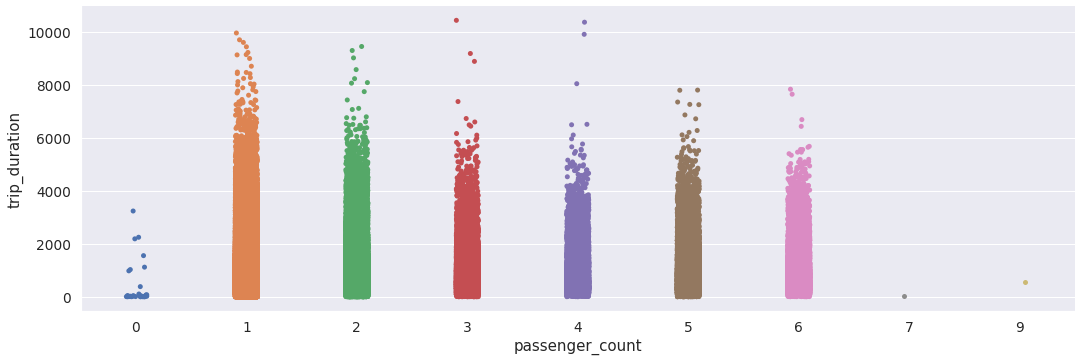

In [108]:
sns.catplot( x = 'passenger_count', y = 'trip_duration', data = df, aspect = 3)

#### Observation of Pickup Days in Relation to the Trip Duration

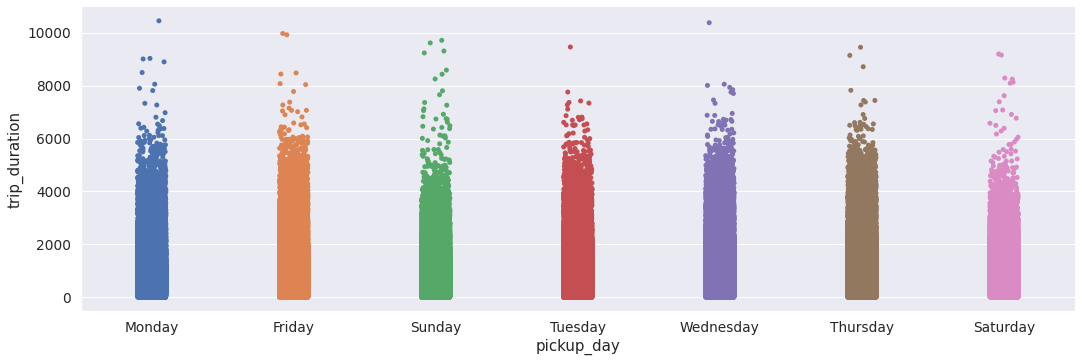

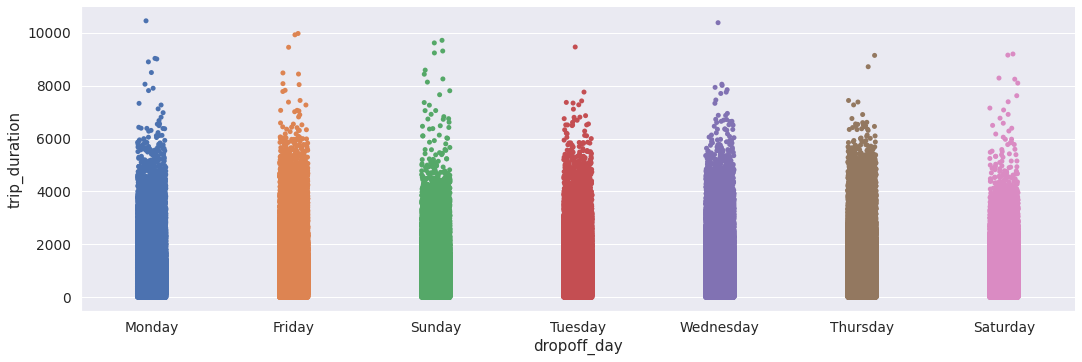

In [106]:
sns.catplot( x = 'pickup_day', y = 'trip_duration', data = df, aspect = 3)

sns.catplot( x = 'dropoff_day', y = 'trip_duration', data = df, aspect = 3)

Monday and Wednesday records the highest trip duration 

## Average Trip Duration by Day

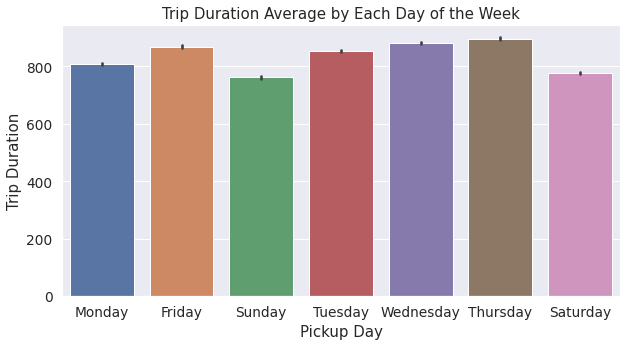

In [144]:
plt.figure(figsize = (10,5))
ax = sns.barplot( x = 'pickup_day', y = 'trip_duration', data = df)
ax.set(xlabel = 'Pickup Day', ylabel = 'Trip Duration')
plt.title('Trip Duration Average by Each Day of the Week')
plt.show()

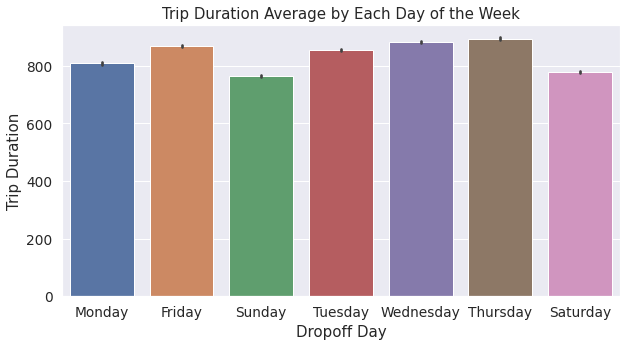

In [145]:
plt.figure(figsize = (10,5))
ax = sns.barplot( x = 'dropoff_day', y = 'trip_duration', data = df)
ax.set(xlabel = 'Dropoff Day', ylabel = 'Trip Duration')
plt.title('Trip Duration Average by Each Day of the Week')
plt.show()

#### Observation of Hours Based on The Trip Duration

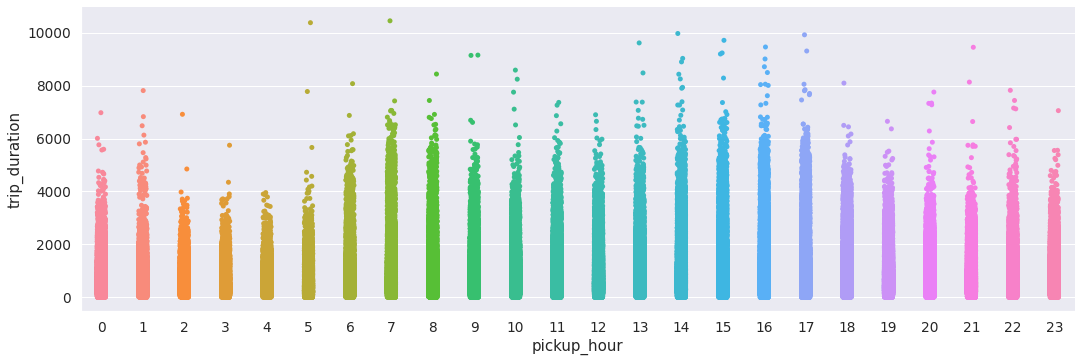

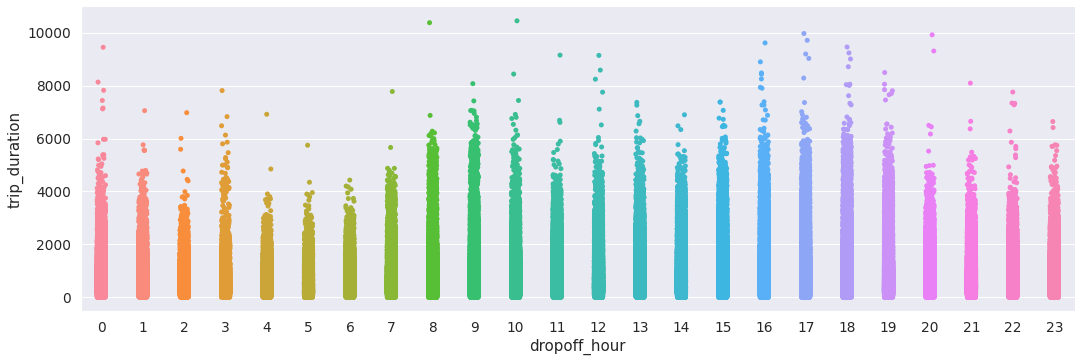

In [109]:

sns.catplot(x = 'pickup_hour', y = 'trip_duration', data = df, aspect = 3)

sns.catplot(x = 'dropoff_hour', y = 'trip_duration', data = df, aspect = 3)

## Trip Duration Based on Hour

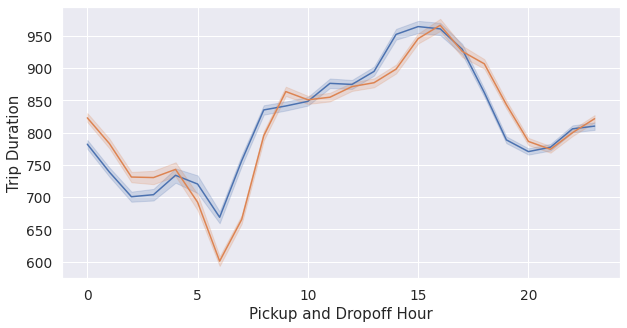

In [114]:
plt.figure(figsize = (10,5))
ax = sns.lineplot( x = 'pickup_hour', y = 'trip_duration', data = df)
ax.set(xlabel = 'Pickup and Dropoff Hour', ylabel = 'Trip Duration')
ax1 = sns.lineplot( x = 'dropoff_hour', y = 'trip_duration', data = df)


The highest average duration spent on a trip occurs at 15:00 hours. This could be due to traffic jam within NYC area

# Summary

* This dataset reflects taxi trips carried out within the NYC area over a span of 6months.

* There are two major vendors under which all drivers with a specific id fall under

* There are 33 rows which has its number of passengers recorded as 0. This could be because the driver was trying to meet a certain target. The reason for this cannot be ascertained till the drivers are further probed

* There were some major outliers in our target variable (trip_duration and dist_in_km). After due research, a decision was reached to drop some of the outliers for better analysis

* Vendor_id 2 covers 53.48% of this dataset while vendor_id 1 covers 46.52% 

* Less than 1% of the drivers store trips before fowarding

* Most of the trips have only 1 passenger, but the occurence of 7 and 9 passengers was once.

* More trips are recorded between 18:00 and 19:00 hours

*  Trips are more frequent on Fridays and Saturdays

*  There is a +0.8 correlation between the trip duration and the distance

* In the early hours of the day (0-5), the average distance travelled is on the rise, sunday has the highest distance covered among the days of the week.

* From 5 am, the time spent on a trip starts to rise and it peaks between 15:00 and 16:00 hours then starts to drop again.